In [2]:
%matplotlib inline
import numpy 
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
cosmo = FlatLambdaCDM(70.0, 0.30)
plt.style.use('jpg')

Mag = lambda m, D_L: m - 5*np.log10(D_L/u.pc) + 5

In [3]:
fn = '../hsc-hugs-paper-I/data/size_vs_mag/sizetable.txt'
brodie = np.genfromtxt(fn,
                       names=('id', 'host', 'M_V', 'logr', 'ref'),
                       dtype='S10,S10,f8,f8,S10')
harris = Table.read('data/Harris-GCs.fits')
harris = harris[harris['Ngc']>0]
harris = harris[~np.isnan(harris['Dist'])]
harris = harris[~np.isnan(harris['Reff'])]

In [4]:
g_V = 0.14 # Fukugita 1995
data = {
    'name': ['DF44', 'DF17', 'VCC 1287'],
    'Ngc': [100, 27, 22],
    'err_top': [25, 5, 8],
    'err_bot': [20, 5, 8],
    'V': [-16.08, -15.1, -14 - g_V],
    'r_eff': [4.6, 4.4, 2.4/np.sqrt(0.8)]
}
data = Table(data)

In [5]:
clust = {
    2.1: Table.read('data/clust_2.1_fits_g-band.csv'), 
    3.1: Table.read('data/clust_3.1_fits_g-band.csv')
}
clust[2.1]['z'] = 0.01723567
clust[3.1]['z'] = 0.02064937
for _id in [2.1, 3.1]:
    clust[_id]['clust-id'] = _id
    clust[_id]['Mg'] = Mag(clust[_id]['m_tot'], cosmo.luminosity_distance(clust[_id]['z']).to('pc'))
    clust[_id]['V'] = clust[_id]['Mg'] - g_V
candy = vstack([clust[2.1], clust[3.1]])
candy['r_kpc'] = candy['r_e']*cosmo.angular_diameter_distance(candy['z']).to('kpc').value*u.arcsec.to('rad')
candy = candy[candy['r_kpc']>1.5]
candy.sort('V')
candy.reverse()

In [6]:
import matplotlib.patches as patches

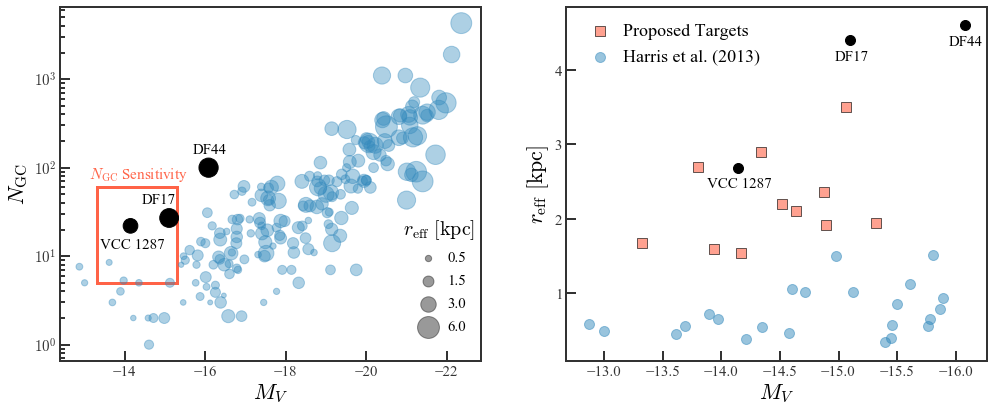

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

ax, ax2 = axes

scale_size = 80
alpha_size = 0.4

sample_color = 'tomato'

cut = (harris['Reff']<6.0) & (harris['Dist']<20.0)

ax.scatter(harris[cut]['VMag'], harris[cut]['Ngc'], alpha=alpha_size, 
           s=scale_size*harris[cut]['Reff'], label=None)

Nvals = np.logspace(3., 4.5, len(candy))

ax.text(-13.1, 75, '$N_\mathrm{GC}$ Sensitivity', fontsize=15, color=sample_color)

ax.scatter(data['V'], data['Ngc'], s=scale_size*data['r_eff'], label=None, c='k')
for udg in data:
    shift = -0.45 if udg['name']=='VCC 1287' else 0.45
    xshift = 0.3 if udg['name']=='DF17' else 0.0
    ax.text(udg['V']-0.04 + xshift, udg['Ngc']+shift*udg['Ngc'], udg['name'], ha='center', fontsize=15)

for size in [0.5, 1.5, 3.0, 6.0]:
    ax.scatter([], [], c='k', alpha=alpha_size, s=size*scale_size, label=str(size))
leg = ax.legend(loc=(0.8, .06), fontsize=15, labelspacing=0.6,
                title='$r_\mathrm{eff}\ \mathrm{[kpc]}$')
plt.setp(leg.get_title(), fontsize=20)

box = patches.Rectangle([-13.3, 5.0], 
                        height=55, 
                        width=-2, 
                        color=sample_color,
                        fill=False, 
                        zorder=-100, 
                        lw=3.)

ax2.scatter(candy['V'], candy['r_kpc'], c=sample_color, 
             edgecolor='k', alpha=0.6, marker='s', s=100, label='Proposed Targets')
ax2.scatter(eye_V, eye_r_eff, c=sample_color, 
             edgecolor='k', alpha=0.6, marker='s', s=100)
ax2.set_xlabel('$M_V$')
ax2.set_ylabel('$r_\mathrm{eff}\ \mathrm{[kpc]}$')
ax2.scatter(data['V'], data['r_eff'], label=None, c='k', s=100)
for udg in data:
    shift = -0.45 if udg['name']=='VCC 1287' else 0.45
    xshift = 0.3 if udg['name']=='DF17' else 0.0
    ax2.text(udg['V']-0.01, udg['r_eff']-0.27, udg['name'], ha='center', fontsize=15)

cut &= harris['VMag']>-16
ax2.scatter(harris[cut]['VMag'], harris[cut]['Reff'], s=100,
            alpha=alpha_size+0.1, label='Harris et al. (2013)')
ax2.invert_xaxis()
ax2.legend(loc='upper left', fontsize=18)


ax.add_patch(box) 
ax.set_yscale('log')
ax.set_ylabel('$N_\mathrm{GC}$')
ax.set_xlabel('$M_V$')
ax.invert_xaxis()
fig.savefig('figures/Ngc_vs_MV.pdf')